### Lien Utile :

- [OCR CAPTCHA KERAS DOC](https://keras.io/examples/vision/captcha_ocr/)
- [Explanation Model](https://harald-scheidl.medium.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)

CAPTCHA -> CNN -> RNN -> CTC -> Pred

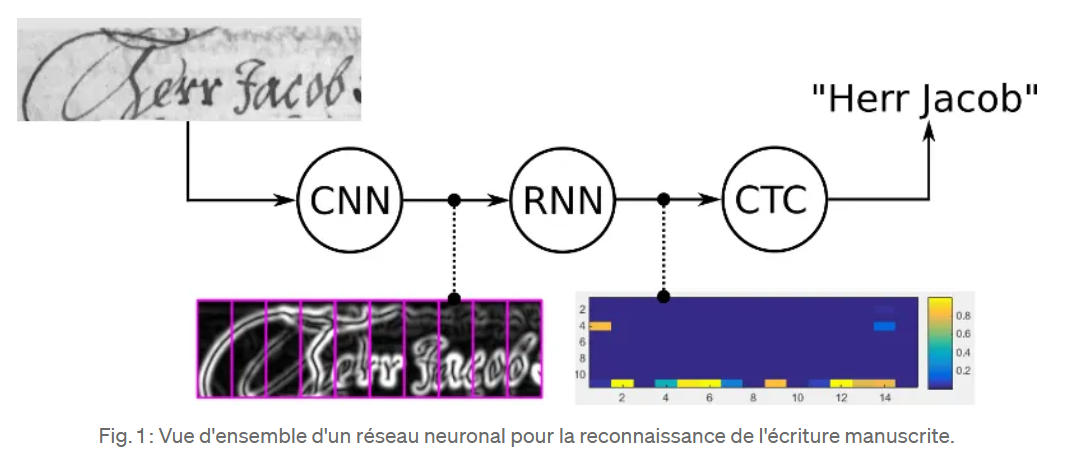

## Importation

**TensorFlow est le moteur de calcul :**

- il manipule des tensors (tableaux de nombres),
- exécute les calculs rapidement (CPU / GPU),
- calcule automatiquement les gradients pour l’apprentissage.

C’est ce qui fait tourner le réseau

**Keras est l’outil de construction :**

- il fournit des couches (CNN, LSTM, Dense…),
- permet d’assembler un modèle,
- gère l’entraînement et les prédictions.

C’est ce qui permet de créer et entraîner le réseau facilement.

In [13]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import zipfile
import tensorflow as tf
import keras
from keras import ops
from keras import layers # pour construire les couches

In [14]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# with zipfile.ZipFile("./captcha_images_v2.zip", "r") as zip_ref:
#     zip_ref.extractall("../data/")

Ce code sert à préparer le dataset CAPTCHA pour l’OCR :
- localiser les images
- extraire les labels (le texte du CAPTCHA)
- analyser les caractères possibles
- définir les paramètres clés pour le modèle CNN + RNN + CTC

Le batch size, c’est le nombre d’exemples traités en même temps par le réseau avant de mettre à jour les poids.

Le modèle prend batch_size images

- Il fait le forward pass
- Il calcule la loss
- Il fait le backpropagation
- Il met à jour les poids
- Puis il passe au batch suivant

Le facteur de sous-échantillonnage "downsample_factor" correspond à la réduction spatiale induite par les couches convolutionnelles et de pooling. Il détermine la longueur de la séquence traitée par le réseau récurrent.”

In [15]:
# ================= LOAD DATASETS =================

old_data_dir = Path("../data/captcha_images_v2/")
new_data_dir = Path("./data/captcha_dataset/")

# --- ancien dataset ---
old_images = sorted(list(old_data_dir.glob("*.png")))
old_labels = [img.stem for img in old_images]

# --- nouveau dataset (10 %) ---
new_images_all = sorted(list(new_data_dir.glob("*.png")))

np.random.seed(42)
n_new = int(1 * len(new_images_all))
new_images = list(np.random.choice(new_images_all, size=n_new, replace=False))
new_labels = [img.stem for img in new_images]

# --- fusion ---
images = old_images + new_images
labels = old_labels + new_labels

images = np.array([str(p) for p in images])
labels = np.array(labels)

print("Ancien dataset :", len(old_images))
print("Nouveau dataset (10%) :", len(new_images))
print("Total images :", len(images))

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Nombre de caractères :", len(characters))
print("Vocabulaire :", characters)


# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Ancien dataset : 1040
Nouveau dataset (10%) : 999
Total images : 2039
Nombre de caractères : 36
Vocabulaire : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


encoder les caractères, Les réseaux de neurones ne comprennent que des nombres.

In [16]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

décoder les prédictions, Pour lire la sortie du modèle et afficher le texte prédit

In [17]:
# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

séparer train / validation (il faudra faire un test plus tard)

In [18]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = ops.arange(size)
    if shuffle:
        indices = keras.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

encode_single_sample =  préparer UNE image, Elle transforme une image brute + son texte en entrée utilisable par le modèle.

In [19]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = ops.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = ops.transpose(img, axes=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # on creer un lazy dataset, les image sont chargé au moment du modele pour gain de memoir eet performance
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE) # On transforme l'image brut en tensor pret pour le modèle
    .batch(batch_size) # on entraine pas le modele image par image mais des batch d'un coup (=16 images + 16 lables) à chaque epoch le modele voit tt le dataset et taite 16 par 16 images
    .prefetch(buffer_size=tf.data.AUTOTUNE) # pendant que le modèle s’entraîne sur le batch N, TensorFlow prépare le batch N+1
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

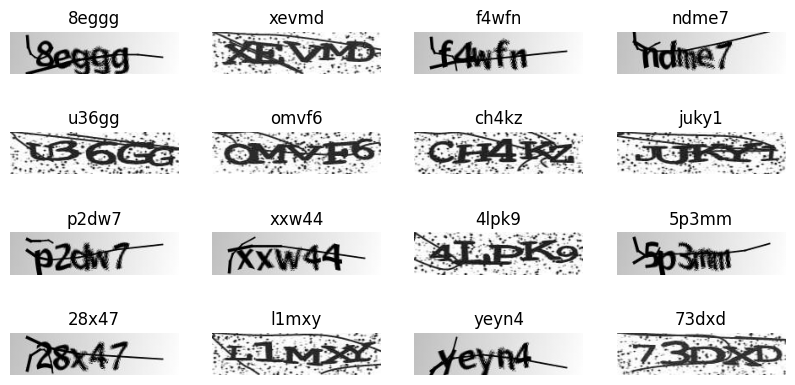

In [21]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

- ctc_batch_cost : Calculer la CTC loss, c’est-à-dire mesurer à quel point la prédiction du modèle correspond au vrai texte, sans savoir où sont les caractères dans l’image.

In [22]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"), 
        vals_sparse, 
        ops.cast(label_shape, dtype="int64")
    )

Image
 1. CNN (voir les formes)
 2. Reshape (image → séquence)
 3. RNN (lire la séquence)
 4. Softmax (probabilités de caractères)
 5. CTC (comparer au vrai mot)


1. CNN — extraction de caractéristiques visuelles

Le CNN est composé de plusieurs blocs de convolution et de pooling.

Couches de convolution (Conv2D) :
détectent des motifs locaux dans l’image (bords, courbes, traits de lettres).

Couches de pooling (MaxPooling) :
réduisent la taille de l’image tout en conservant l’information importante, ce qui rend le modèle plus robuste et plus rapide.

À la sortie du CNN, l’image est transformée en une carte de caractéristiques riche, mais encore spatiale.

2. Reshape — transformation image → séquence

Le reshape transforme la sortie 2D du CNN en une séquence 1D.

Chaque colonne de l’image (après CNN) devient un pas de temps

Chaque pas de temps est décrit par un vecteur de caractéristiques

Cette étape est indispensable pour permettre au RNN de lire l’image de gauche à droite.

3. RNN (BiLSTM) — modélisation de la séquence

Le RNN traite la séquence produite par le reshape.

Il lit la séquence dans l’ordre temporel

En version bidirectionnelle, il utilise le contexte à gauche et à droite

Il apprend les dépendances entre caractères voisins

À la sortie du RNN, on obtient une représentation contextuelle à chaque pas de temps.

4. Dense + Softmax — probabilités de caractères

La couche Dense projette chaque pas de temps vers l’espace des caractères possibles.

Softmax transforme les scores en probabilités

Pour chaque pas de temps, on obtient une distribution de probabilité sur :

chaque caractère du vocabulaire

le symbole blank

Cette sortie représente ce que le modèle pense voir à chaque position.

5. CTC — comparaison avec le mot réel

La CTC loss compare la séquence de probabilités produite par le modèle avec le mot réel.

Elle ne suppose aucun alignement caractère–image

Elle autorise répétitions et blancs

Elle pénalise le modèle uniquement si le mot réel est improbable ou impossible à obtenir

Cette loss permet l’apprentissage sans segmentation explicite des caractères.

In [23]:


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    197,632 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 50, 128)   │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 38)    │      4,902 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 38)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 434,918 (1.66 MB)

 Trainable params: 434,918 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# TODO restore epoch count.
epochs = 200
early_stopping_patience = 20
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - loss: 357.1455 - val_loss: 299.7688
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 303.6063 - val_loss: 299.4506
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 272ms/step - loss: 301.7705 - val_loss: 294.0915
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 291.7932 - val_loss: 286.9213
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 288.1251 - val_loss: 285.8047
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 287.4152 - val_loss: 285.4666
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 286.8539 - val_loss: 284.8041
Epoch 8/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 286.3857 - val_loss: 284.3909
Epoch 9/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 284.4750 - val_loss: 278.8402
Epoch 10/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 275.6154 - val_loss: 266.9736
Epoch 11/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 259.2868 - 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 38)         │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,918 (1.66 MB)

 Trainable params: 434,918 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


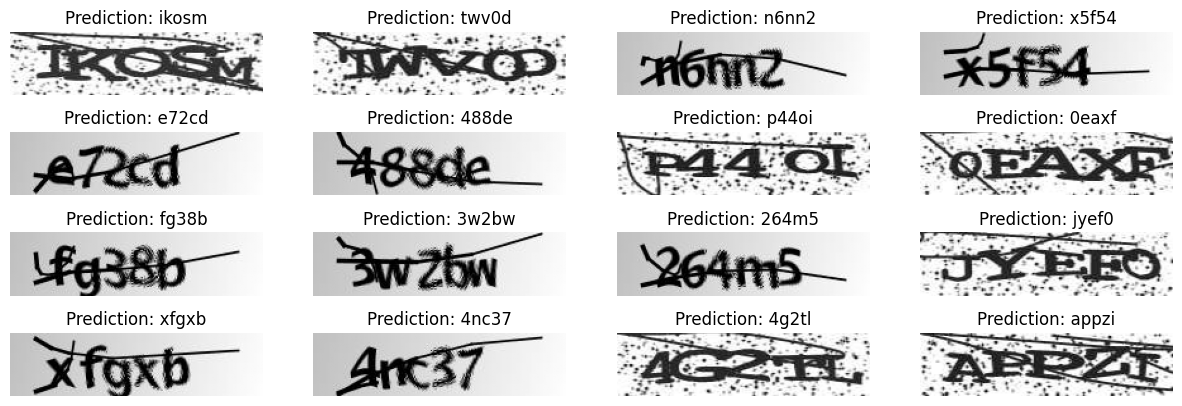

In [25]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [26]:
def levenshtein(a, b):
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n

    current = list(range(n + 1))
    for i in range(1, m + 1):
        previous, current = current, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete = previous[j] + 1, current[j - 1] + 1
            change = previous[j - 1]
            if a[j - 1] != b[i - 1]:
                change += 1
            current[j] = min(add, delete, change)

    return current[n]


def evaluate_ocr(
    prediction_model,
    validation_dataset,
    num_to_char,
    max_length,
):
    total_chars = 0
    total_errors = 0
    exact_matches = 0
    total_samples = 0

    for batch in validation_dataset:
        images = batch["image"]
        labels = batch["label"]

        preds = prediction_model.predict(images, verbose=0)
        pred_texts = decode_batch_predictions(preds)

        true_texts = []
        for label in labels:
            text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            true_texts.append(text)

        for true, pred in zip(true_texts, pred_texts):
            dist = levenshtein(true, pred)

            total_errors += dist
            total_chars += len(true)
            exact_matches += int(true == pred)
            total_samples += 1

    cer = total_errors / total_chars
    exact_acc = exact_matches / total_samples

    return {
        "CER": cer,
        "Character Accuracy": 1 - cer,
        "Exact Match Accuracy": exact_acc,
    }

metrics = evaluate_ocr(
    prediction_model,
    validation_dataset,
    num_to_char,
    max_length,
)

print(" OCR Performance")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


 OCR Performance
CER: 0.0216
Character Accuracy: 0.9784
Exact Match Accuracy: 0.9020


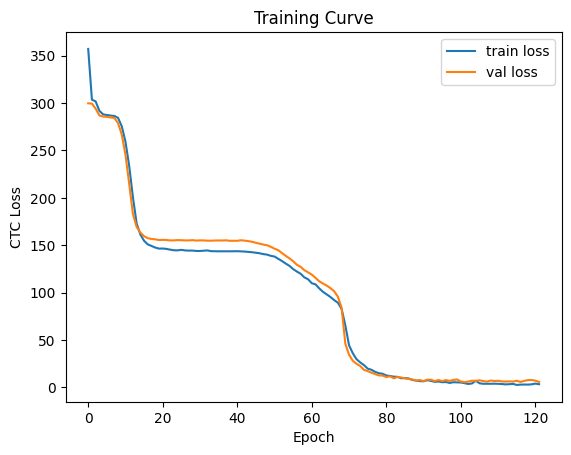

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training Curve")
plt.show()


In [38]:
# ================= TEST SUR UNE IMAGE =================

import tensorflow as tf
from pathlib import Path

# 👉 CHANGE JUSTE CE PATH
IMAGE_PATH = Path("./data/captcha_dataset/11c1t.png")

# --- preprocessing (identique au training) ---
def preprocess_single_image(img_path):
    # Lecture en bytes (safe Windows)
    img_bytes = Path(img_path).read_bytes()

    img = tf.io.decode_png(img_bytes, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])  # width = time
    img = tf.expand_dims(img, axis=0)        # batch
    return img



# --- inference ---
img = preprocess_single_image(IMAGE_PATH)

preds = prediction_model.predict(img, verbose=0)

pred_text = decode_batch_predictions(preds, num_to_char)[0]

print("Image :", IMAGE_PATH.name)
print("GT    :", IMAGE_PATH.stem)
print("Pred  :", pred_text)

Image : 11c1t.png
GT    : 11c1t
Pred  : 11c1t
